In [2]:
import re
import numpy as np
import nltk
import matplotlib.pyplot as plt

def mapping(tokens):
    word_to_id = dict()
    id_to_word = dict()

    for i, token in enumerate(set(tokens)):
        word_to_id[token] = i
        id_to_word[i] = token

    return word_to_id, id_to_word

def generate_training_data(tokens, word_to_id, window_size):
    N = len(tokens)
    X, Y = [], []

    for i in range(N):
        nbr_inds = list(range(max(0, i - window_size), i)) + \
                   list(range(i + 1, min(N, i + window_size + 1)))
        for j in nbr_inds:
            X.append(word_to_id[tokens[i]])
            Y.append(word_to_id[tokens[j]])
            
    X = np.array(X)
    X = np.expand_dims(X, axis=0)
    Y = np.array(Y)
    Y = np.expand_dims(Y, axis=0)

    return X, Y

In [3]:

def initialize_wrd_emb(vocab_size, emb_size):
    """
    vocab_size: int. vocabulary size of your corpus or training data
    emb_size: int. word embedding size. How many dimensions to represent each vocabulary
    """
    WRD_EMB = np.random.randn(vocab_size, emb_size) * 0.01
    return WRD_EMB

def initialize_dense(input_size, output_size):
    """
    input_size: int. size of the input to the dense layer
    output_szie: int. size of the output out of the dense layer
    """
    W = np.random.randn(output_size, input_size) * 0.01
    return W

def initialize_parameters(vocab_size, emb_size):
    """
    initialize all the trianing parameters
    """
    WRD_EMB = initialize_wrd_emb(vocab_size, emb_size)
    W = initialize_dense(emb_size, vocab_size)
    
    parameters = {}
    parameters['WRD_EMB'] = WRD_EMB
    parameters['W'] = W
    
    return parameters

In [4]:
def ind_to_word_vecs(inds, parameters):
    """
    inds: numpy array. shape: (1, m)
    parameters: dict. weights to be trained
    """
    m = inds.shape[1]
    WRD_EMB = parameters['WRD_EMB']
    word_vec = WRD_EMB[inds.flatten(), :].T
    
    assert(word_vec.shape == (WRD_EMB.shape[1], m))
    
    return word_vec

def linear_dense(word_vec, parameters):
    """
    word_vec: numpy array. shape: (emb_size, m)
    parameters: dict. weights to be trained
    """
    m = word_vec.shape[1]
    W = parameters['W']
    Z = np.dot(W, word_vec)
    
    assert(Z.shape == (W.shape[0], m))
    
    return W, Z

def softmax(Z):
    """
    Z: output out of the dense layer. shape: (vocab_size, m)
    """
    softmax_out = np.divide(np.exp(Z), np.sum(np.exp(Z), axis=0, keepdims=True) + 0.001)
    
    assert(softmax_out.shape == Z.shape)

    return softmax_out

def forward_propagation(inds, parameters):
    word_vec = ind_to_word_vecs(inds, parameters)
    W, Z = linear_dense(word_vec, parameters)
    softmax_out = softmax(Z)
    
    caches = {}
    caches['inds'] = inds
    caches['word_vec'] = word_vec
    caches['W'] = W
    caches['Z'] = Z
    
    return softmax_out, caches

In [5]:
def cross_entropy(softmax_out, Y):
    """
    softmax_out: output out of softmax. shape: (vocab_size, m)
    """
    m = softmax_out.shape[1]
    cost = -(1 / m) * np.sum(np.sum(Y * np.log(softmax_out + 0.001), axis=0, keepdims=True), axis=1)
    return cost

In [6]:
def softmax_backward(Y, softmax_out):
    """
    Y: labels of training data. shape: (vocab_size, m)
    softmax_out: output out of softmax. shape: (vocab_size, m)
    """
    dL_dZ = softmax_out - Y
    
    assert(dL_dZ.shape == softmax_out.shape)
    return dL_dZ

def dense_backward(dL_dZ, caches):
    """
    dL_dZ: shape: (vocab_size, m)
    caches: dict. results from each steps of forward propagation
    """
    W = caches['W']
    word_vec = caches['word_vec']
    m = word_vec.shape[1]
    
    dL_dW = (1 / m) * np.dot(dL_dZ, word_vec.T)
    dL_dword_vec = np.dot(W.T, dL_dZ)

    assert(W.shape == dL_dW.shape)
    assert(word_vec.shape == dL_dword_vec.shape)
    
    return dL_dW, dL_dword_vec

def backward_propagation(Y, softmax_out, caches):
    dL_dZ = softmax_backward(Y, softmax_out)
    dL_dW, dL_dword_vec = dense_backward(dL_dZ, caches)
    
    gradients = dict()
    gradients['dL_dZ'] = dL_dZ
    gradients['dL_dW'] = dL_dW
    gradients['dL_dword_vec'] = dL_dword_vec
    
    return gradients

def update_parameters(parameters, caches, gradients, learning_rate):
    vocab_size, emb_size = parameters['WRD_EMB'].shape
    inds = caches['inds']
    WRD_EMB = parameters['WRD_EMB']
    dL_dword_vec = gradients['dL_dword_vec']
    m = inds.shape[-1]
    
    WRD_EMB[inds.flatten(), :] -= dL_dword_vec.T * learning_rate

    parameters['W'] -= learning_rate * gradients['dL_dW']

In [7]:
def skipgram_model_training(X, Y, vocab_size, emb_size, learning_rate, epochs, batch_size=256, parameters=None, print_cost=True, plot_cost=True):
    """
    X: Input word indices. shape: (1, m)
    Y: One-hot encoding of output word indices. shape: (vocab_size, m)
    vocab_size: vocabulary size of your corpus or training data
    emb_size: word embedding size. How many dimensions to represent each vocabulary
    learning_rate: alaph in the weight update formula
    epochs: how many epochs to train the model
    batch_size: size of mini batch
    parameters: pre-trained or pre-initialized parameters
    print_cost: whether or not to print costs during the training process
    """
    costs = []
    m = X.shape[1]
    
    if parameters is None:
        parameters = initialize_parameters(vocab_size, emb_size)
    
    for epoch in range(epochs):
        epoch_cost = 0
        batch_inds = list(range(0, m, batch_size))
        np.random.shuffle(batch_inds)
        for i in batch_inds:
            X_batch = X[:, i:i+batch_size]
            Y_batch = Y[:, i:i+batch_size]

            softmax_out, caches = forward_propagation(X_batch, parameters)
            gradients = backward_propagation(Y_batch, softmax_out, caches)
            update_parameters(parameters, caches, gradients, learning_rate)
            cost = cross_entropy(softmax_out, Y_batch)
            epoch_cost += np.squeeze(cost)
            
        costs.append(epoch_cost)
        if print_cost and epoch % (epochs // 500) == 0:
            print("Cost after epoch {}: {}".format(epoch, epoch_cost))
        if epoch % (epochs // 100) == 0:
            learning_rate *= 0.98
            
    if plot_cost:
        plt.plot(np.arange(epochs), costs)
        plt.xlabel('# of epochs')
        plt.ylabel('cost')
    return parameters

Cost after epoch 0: 2.75680356264453
Cost after epoch 10: 2.7565495917078153
Cost after epoch 20: 2.7562847143743987
Cost after epoch 30: 2.755992379847787
Cost after epoch 40: 2.7556558325546927
Cost after epoch 50: 2.75525712276606
Cost after epoch 60: 2.7547860744644423
Cost after epoch 70: 2.754216733264153
Cost after epoch 80: 2.7535251162365477
Cost after epoch 90: 2.752684993906825
Cost after epoch 100: 2.7516664198860896
Cost after epoch 110: 2.750459266692647
Cost after epoch 120: 2.7490129260239016
Cost after epoch 130: 2.747282880553974
Cost after epoch 140: 2.745220928756987
Cost after epoch 150: 2.742772375342675
Cost after epoch 160: 2.7399318694608756
Cost after epoch 170: 2.7366011967973836
Cost after epoch 180: 2.732703597973841
Cost after epoch 190: 2.7281614273184998
Cost after epoch 200: 2.7228918983936126
Cost after epoch 210: 2.7169258009122497
Cost after epoch 220: 2.710108159180422
Cost after epoch 230: 2.7023497577029203
Cost after epoch 240: 2.69358123514477
C

Cost after epoch 2140: 2.110402335234635
Cost after epoch 2150: 2.1103273504810076
Cost after epoch 2160: 2.110262449682369
Cost after epoch 2170: 2.1102062016065912
Cost after epoch 2180: 2.110158382967751
Cost after epoch 2190: 2.1101189018320277
Cost after epoch 2200: 2.1100876505168356
Cost after epoch 2210: 2.1100649042805126
Cost after epoch 2220: 2.1100498725021457
Cost after epoch 2230: 2.1100423494689524
Cost after epoch 2240: 2.1100421761344124
Cost after epoch 2250: 2.1100491801360697
Cost after epoch 2260: 2.110062914102629
Cost after epoch 2270: 2.1100831604663557
Cost after epoch 2280: 2.110109736289048
Cost after epoch 2290: 2.110142432585697
Cost after epoch 2300: 2.11018103018284
Cost after epoch 2310: 2.110224502934751
Cost after epoch 2320: 2.110273120792433
Cost after epoch 2330: 2.1103267286783387
Cost after epoch 2340: 2.110385086831005
Cost after epoch 2350: 2.110447948928492
Cost after epoch 2360: 2.110513864718593
Cost after epoch 2370: 2.1105834952740516
Cost 

Cost after epoch 4410: 2.131867089532102
Cost after epoch 4420: 2.1320157657787515
Cost after epoch 4430: 2.1321642195597392
Cost after epoch 4440: 2.1323124320517257
Cost after epoch 4450: 2.1324603844772834
Cost after epoch 4460: 2.1326054080276715
Cost after epoch 4470: 2.1327498513002965
Cost after epoch 4480: 2.132893991713198
Cost after epoch 4490: 2.1330378117181397
Cost after epoch 4500: 2.1331812938318806
Cost after epoch 4510: 2.1333218528574998
Cost after epoch 4520: 2.133461768365667
Cost after epoch 4530: 2.1336013100555866
Cost after epoch 4540: 2.1337404616705493
Cost after epoch 4550: 2.133879207034576
Cost after epoch 4560: 2.1340150491251784
Cost after epoch 4570: 2.134150194089178
Cost after epoch 4580: 2.1342849033848705
Cost after epoch 4590: 2.1344191620465756
Cost after epoch 4600: 2.134552955202004
Cost after epoch 4610: 2.134683877640858
Cost after epoch 4620: 2.1348140584955586
Cost after epoch 4630: 2.134943750548264
Cost after epoch 4640: 2.1350729401092257


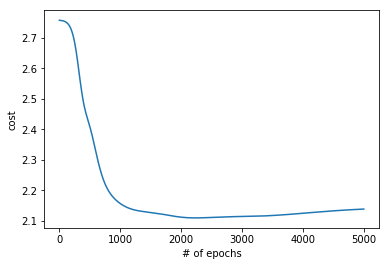

In [8]:
def word2vec(vocab, )
doc = "After the deduction of the costs of investing, " \
      "beating the stock market is a loser's game."
tokens = nltk.word_tokenize(doc)
word_to_id, id_to_word = mapping(tokens)
X, Y = generate_training_data(tokens, word_to_id, 3)
vocab_size = len(id_to_word)
m = Y.shape[1]
# turn Y into one hot encoding
Y_one_hot = np.zeros((vocab_size, m))
Y_one_hot[Y.flatten(), np.arange(m)] = 1

paras = skipgram_model_training(X, Y_one_hot, vocab_size, 50, 0.05, 5000, batch_size=128, parameters=None, print_cost=True)

In [15]:
X_test = np.arange(vocab_size)
X_test = np.expand_dims(X_test, axis=0)
softmax_test, _ = forward_propagation(X_test, paras)
top_sorted_inds = np.argsort(softmax_test, axis=0)[-4:,:]

In [16]:
for input_ind in range(vocab_size):
    input_word = id_to_word[input_ind]
    output_words = [id_to_word[output_ind] for output_ind in top_sorted_inds[::-1, input_ind]]
    print("{}'s neighbor words: {}".format(input_word, output_words))

beating's neighbor words: ['market', 'stock', 'the', 'investing']
of's neighbor words: ['the', 'costs', 'beating', 'of']
investing's neighbor words: ['the', 'of', ',', 'beating']
stock's neighbor words: ['a', 'is', ',', 'market']
market's neighbor words: ['loser', 'stock', 'is', 'beating']
the's neighbor words: ['is', 'market', 'stock', 'the']
's's neighbor words: ['.', 'a', 'game', "'s"]
deduction's neighbor words: ['costs', 'After', 'the', 'of']
,'s neighbor words: ['stock', 'the', 'beating', 'costs']
.'s neighbor words: ['loser', "'s", 'game', 'stock']
a's neighbor words: ['loser', "'s", 'game', 'stock']
is's neighbor words: ['loser', "'s", 'market', 'a']
game's neighbor words: ['.', 'a', 'game', "'s"]
After's neighbor words: ['of', 'the', 'deduction', 'costs']
loser's neighbor words: ['.', 'a', 'game', "'s"]
costs's neighbor words: [',', 'of', 'deduction', 'the']


In [25]:
softmax_test, _ = forward_propagation(np.array([[word_to_ind(i) for i in 'market stock']]), paras)

NameError: name 'word_to_ind' is not defined

In [15]:
print(word_to_id)

{'investing': 0, 'stock': 1, 'market': 2, 'costs': 3, 'game': 4, 'is': 5, 'beating': 6, 'loser': 7, '.': 8, 'the': 9, 'a': 10, "'s": 11, ',': 12, 'After': 13, 'deduction': 14, 'of': 15}


In [13]:
np.mean(forward_propagation(np.array([[word_to_id[i] for i in ['market', 'loser']]]), paras)[1]['word_vec'], axis=1)

array([-1.36258346e+00, -1.51939799e-01,  1.79864933e+00,  7.46485077e-02,
        1.71707055e+00,  1.39494030e+00, -2.43966187e-01,  1.10499878e+00,
        1.93225486e+00,  1.10024962e+00,  1.42644762e+00, -3.44037421e-02,
        2.23996543e+00,  6.47172906e-01,  1.16378760e+00, -4.82243024e-02,
        1.24532815e+00,  1.35382484e+00,  4.23859775e-01,  9.64613092e-01,
        8.27896487e-01,  2.85272980e-01, -1.03334034e+00,  9.09670740e-01,
        4.01100181e-01, -2.30575056e-01, -1.51392288e-01,  3.16129068e+00,
       -1.14181876e+00,  1.60410782e-01,  1.52513278e+00,  1.07826358e+00,
       -1.26684035e-01, -1.17992474e+00, -8.34411849e-02,  8.44996298e-01,
       -1.02043837e-01, -1.27448646e+00, -1.53905513e-01, -4.28818251e-01,
        3.45002407e-01,  5.61200505e-01, -1.39268048e+00,  8.08054556e-01,
        6.63052658e-01,  1.57858403e-03,  5.96344511e-01,  8.39148903e-02,
       -2.27390801e-01, -7.28294404e-01])